# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [31]:
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())
openai_api_key = os.environ['OPENAI_API_KEY']

In [32]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-3.5-turbo')

### *Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop

In [33]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
from typing import Annotated

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst"
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic"
    )
    description: str = Field(
        description="Description of the analyst focus, concerns and motives"
    )

    @property
    def persona(self)->str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    
class Perspectives(BaseModel):
    analysts : List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations"
    )

class GenerateAnalystsState(TypedDict):
    topic: str # research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # analyst asking questions

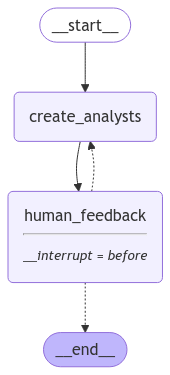

In [34]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instrunctions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    """Create analysts"""

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback',"")

    structured_llm = llm.with_structured_output(Perspectives)

    system_message = analyst_instrunctions.format(topic=topic,
                                                  human_analyst_feedback=human_analyst_feedback,
                                                  max_analysts=max_analysts)
    
    analysts = structured_llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts")])

    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """No-op node that should be interrupted on"""
    pass

def should_continue(state: GenerateAnalystsState):
    """Return the next node to continue"""

    human_analyst_feedback=state.get('human_analyst_feedback',None)
    if human_analyst_feedback:
        return "create_analysts"
    return END

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [35]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Sarah Zhang
Affiliation: TechInsights
Role: Technology Analyst
Description: Sarah specializes in analyzing the latest technologies and their impact on businesses. She is particularly interested in understanding the benefits of adopting new AI frameworks like LangGraph.
--------------------------------------------------
Name: David Lee
Affiliation: DataTech Research
Role: Data Scientist
Description: David is a data scientist with a focus on AI and machine learning frameworks. He is keen on exploring the potential advantages of using LangGraph as an agent framework.
--------------------------------------------------
Name: Amy Chen
Affiliation: FutureTech Labs
Role: Research Scientist
Description: Amy is a research scientist with expertise in emerging technologies. She is passionate about studying the advantages and challenges of adopting LangGraph in various applications.
--------------------------------------------------


In [36]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [37]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efde245-b7fb-60fc-8002-9c618aff05d4'}}

In [38]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Sarah Zhang
Affiliation: TechInsights
Role: Technology Analyst
Description: Sarah specializes in analyzing the latest technologies and their impact on businesses. She is particularly interested in understanding the benefits of adopting new AI frameworks like LangGraph.
--------------------------------------------------
Name: David Lee
Affiliation: DataTech Research
Role: Data Scientist
Description: David is a data scientist with a focus on AI and machine learning frameworks. He is keen on exploring the potential advantages of using LangGraph as an agent framework.
--------------------------------------------------
Name: Amy Chen
Affiliation: FutureTech Labs
Role: Research Scientist
Description: Amy is a research scientist with expertise in emerging technologies. She is passionate about studying the advantages and challenges of adopting LangGraph in various applications.
--------------------------------------------------
Name: Alice
Affiliation: Tech Research Firm
Role: Lead Resea

In [39]:
graph.get_state(thread).values

{'topic': 'The benefits of adopting LangGraph as an agent framework',
 'max_analysts': 3,
 'human_analyst_feedback': 'Add in someone from a startup to add an entrepreneur perspective',
 'analysts': [Analyst(affiliation='Tech Research Firm', name='Alice', role='Lead Research Analyst', description='Alice is an expert in emerging technologies and their impact on businesses. She focuses on evaluating the benefits of adopting new agent frameworks like LangGraph in the tech industry.'),
  Analyst(affiliation='AI Consulting Company', name='Bob', role='AI Solutions Architect', description='Bob specializes in designing and implementing AI solutions for clients across various industries. He is interested in understanding how LangGraph can enhance AI capabilities and improve operational efficiency.'),
  Analyst(affiliation='Startup', name='Charlie', role='Founder and CEO', description='Charlie is a visionary entrepreneur who founded a startup focused on AI solutions. He is keen on exploring the p

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [40]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # FInal key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [41]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [42]:
#web search rool
from langchain_community.tools import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)


In [43]:
#wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

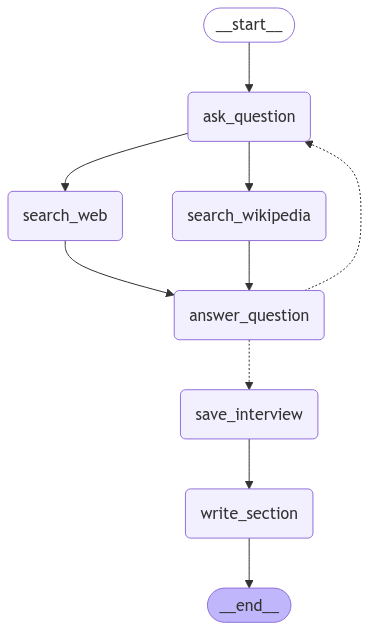

In [44]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [45]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Evaluating LangGraph as a Transformative Agent Framework in the Tech Industry

### Summary

Emerging technologies play a pivotal role in shaping the future of businesses, particularly in the tech industry. LangGraph, a robust framework for building stateful, multi-actor applications with large language models (LLMs), has emerged as a transformative tool with strategic benefits for agent frameworks. By consolidating insights from various analyses, this report delves into the advantages of adopting LangGraph in the tech industry.

1. The LangGraph framework provides built-in support for state management, cyclic workflows, and seamless integration of human input, enabling the development of production-ready AI applications capable of handling complex, multi-step processes [1].
   
2. Proper memory management in LangGraph agents transforms them into sophisticated conversational partners that can maintain context, learn from interactions, and offer personalized responses based on historical data. Its graph-based architecture allows developers to create stateful agents for complex workflows with support for persistence, cycling, and human oversight [2].

3. LangGraph enables developers to customize the graph structure, state, and coordination mechanisms, empowering the creation of sophisticated, multi-actor applications that intelligently adapt to changing inputs. By establishing a well-defined state object, developers can enhance their applications' ability to respond intelligently to varying conditions [3].

4. Furthermore, LangGraph excels in handling complex workflows through graph-based orchestration, persistent state management, and multi-agent coordination, making it well-suited for advanced applications. The framework supports graph-based workflows for dynamic decision-making, cyclical graphs for iterative processes, and integration with LangChain and LangSmith for monitoring and optimization [4].

### Sources
[1] https://dev.to/aragorn_talks/langgraph-tutorial-a-comprehensive-guide-to-building-advanced-ai-agents-l31  
[2] https://dev.to/aragorn_talks/langgraph-tutorial-a-comprehensive-guide-to-building-advanced-ai-agents-l31  
[3] https://www.advancinganalytics.co.uk/blog/effective-query-handling-with-langgraph-agent-framework  
[4] https://www.getzep.com/ai-agents/langchain-agents-langgraph